In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U numpyro blackjax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 18.9 MB/s eta 0:00:00


In [3]:
import arviz as az
import numpy as np
import polars as ps
import pymc as pm
from pytensor import shared
from sklearn.model_selection import train_test_split

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Data

In [5]:
dataset_dir: str = '/content/drive/MyDrive/'

In [6]:
type_map: list = [ps.Int32, ps.Int32, ps.Int32, ps.Int32, ps.Int32, ps.Int32, ps.Int32,
                  ps.Int32, ps.Float32, ps.Float32, ps.Float32, ps.Float32, ps.Float32,
                  ps.Float32, ps.Float32, ps.Float32, ps.Float32, ps.Float32,
                  ps.Float32, ps.Int32, ps.Float32, ps.Float32, ps.Float32]

In [7]:
dataset: ps.DataFrame = ps.read_csv('{}full_dataset_train.csv'.format(dataset_dir), dtypes=type_map, encoding='utf8', n_threads=8, use_pyarrow=True)

In [8]:
dataset.head()

SiteId,PublishYear,PublishMonth,PublishDay,PublishHour,AQI,Pollutant,Status,SO2,SO2_AVG,CO,CO_8hr,O3,O3_8hr,PM10,PM10_AVG,NO,NO2,NOx,WindDirec,WindSpeed,PM2.5,PM2.5_AVG
i32,i32,i32,i32,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32
48,2022,6,1,0,27,0,0,0.9,1.0,0.3,0.1,1.7,14.3,19.0,17.0,3.9,16.5,20.4,85,0.9,7.0,5.0
58,2022,6,1,1,40,0,0,2.1,3.0,0.1,0.1,0.4,3.3,21.0,16.0,22.4,24.6,47.0,237,0.4,13.0,8.0
71,2022,6,1,1,37,0,0,2.1,1.0,0.3,0.2,0.0,7.2,22.0,18.0,6.0,22.200001,28.200001,253,0.5,8.0,7.0
15,2022,6,1,2,23,1,0,0.7,1.0,0.4,0.5,0.7,3.4,16.0,13.0,3.7,14.0,17.799999,70,0.3,9.0,7.0
8,2022,6,1,4,23,1,0,0.6,0.0,0.3,0.5,4.2,3.6,14.0,12.0,1.5,10.3,11.8,161,0.9,8.0,7.0


# Features

In [9]:
features: list = dataset.columns
target_feature: str = 'PM2.5'
features.remove(target_feature)

In [10]:
dataset = dataset.sample(n=200000, shuffle=True, seed=37710)

In [11]:
variables: np.array = np.array([dataset[feature].to_numpy() for feature in features])
variables = variables.transpose()

In [12]:
target: np.array = dataset[target_feature].to_numpy().reshape(1, -1)
target = target.transpose()

In [13]:
train_variables, test_variables, train_target, test_target = train_test_split(variables, target, test_size=0.4, random_state=37710, shuffle=True)

In [14]:
train_variables = shared(train_variables.transpose())
train_target = train_target.transpose()
test_variables = test_variables
test_target = test_target

# Model

In [15]:
with pm.Model() as predictor:
	intercept = pm.Normal(name='intercept', sigma=10)
	coefficients = pm.Normal(name='coefficients', mu=0, sigma=1, shape=len(features))
	error = pm.HalfCauchy(name='error', beta=5)
	model = pm.Deterministic('model', intercept + pm.math.dot(coefficients, train_variables))

	prediction = pm.Normal(name='prediction', mu=model, sigma=error, observed=train_target)

	trace = trace = pm.sample(tune=2000, chains=2, random_seed=37710, cores=8, nuts_sampler='numpyro')
	ppc = pm.sample_posterior_predictive(trace, random_seed=37710)

/usr/local/lib/python3.10/dist-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...


/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:641: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:06.213591
Sampling...


sample: 100%|██████████| 3000/3000 [45:23<00:00,  1.10it/s, 1023 steps of size 2.39e-03. acc. prob=0.93]


Sampling time =  1:29:23.027064
Transforming variables...
Transformation time =  0:00:01.300574


# Performance Analysis

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'coefficients'}>,
        <Axes: title={'center': 'coefficients'}>],
       [<Axes: title={'center': 'error'}>,
        <Axes: title={'center': 'error'}>]], dtype=object)

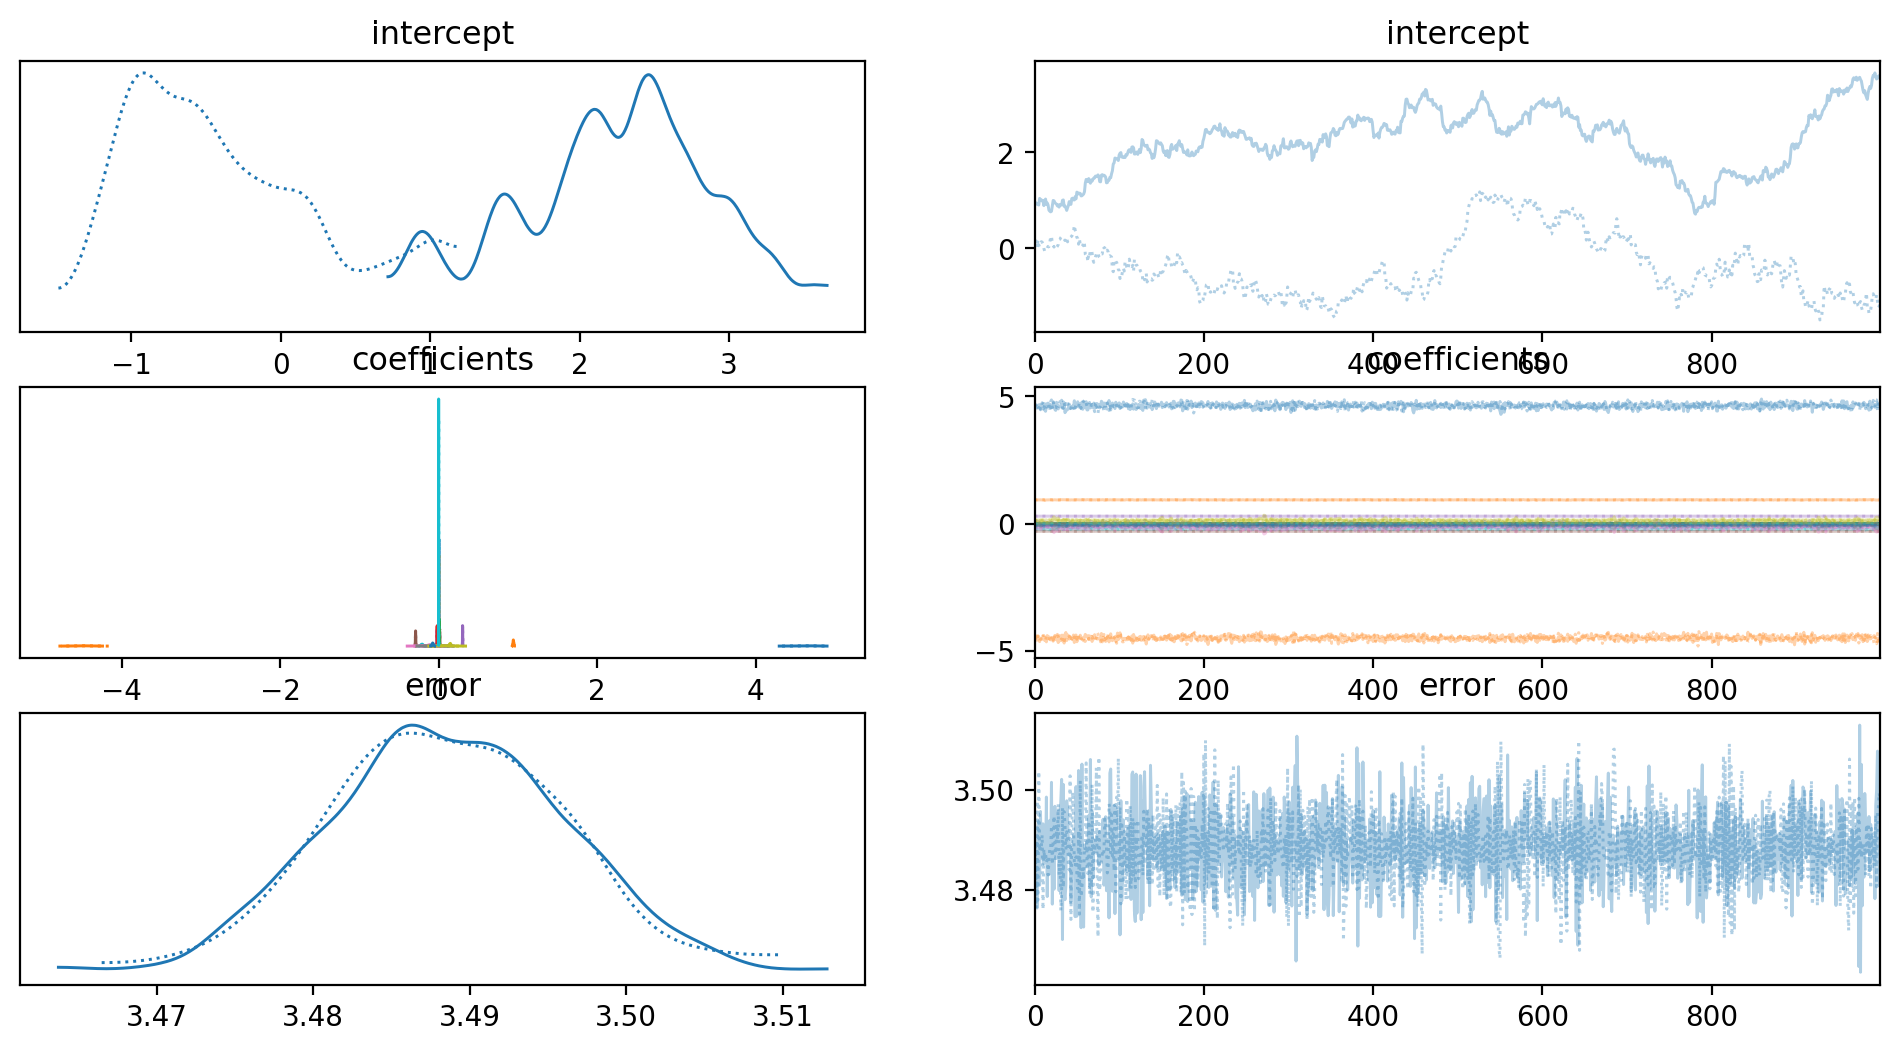

In [16]:
az.plot_trace(trace, var_names=['intercept', 'coefficients', 'error'])

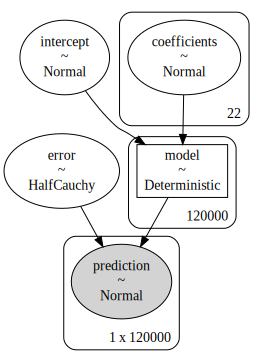

In [36]:
pm.model_to_graphviz(predictor)

In [17]:
summary = az.summary(trace, var_names=['intercept', 'coefficients', 'error'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.926,1.449,-1.276,3.038,0.937,0.766,3.0,21.0,1.85
coefficients[0],0.001,0.000,0.001,0.001,0.000,0.000,1967.0,1239.0,1.00
coefficients[1],-0.000,0.001,-0.001,0.001,0.000,0.000,3.0,21.0,1.85
coefficients[2],0.001,0.003,-0.006,0.007,0.000,0.000,2091.0,1261.0,1.00
coefficients[3],-0.001,0.001,-0.004,0.001,0.000,0.000,4458.0,1380.0,1.00
coefficients[4],-0.020,0.002,-0.022,-0.016,0.000,0.000,3518.0,1405.0,1.00
coefficients[5],0.013,0.002,0.009,0.016,0.000,0.000,920.0,1037.0,1.00
coefficients[6],-0.120,0.022,-0.161,-0.079,0.001,0.000,1379.0,1105.0,1.00
coefficients[7],-0.024,0.039,-0.097,0.050,0.001,0.001,716.0,953.0,1.01
coefficients[8],0.145,0.009,0.130,0.162,0.000,0.000,2783.0,1658.0,1.00


## MSE

In [18]:
mean: list = summary['mean'].to_list()
print('Mean:\nIntercept: {}'.format(mean[0]))
for feature_name, feature_mean in zip(features, mean[1:-1]):
    print('{}: {}'.format(feature_name, feature_mean))
print('Error: {}'.format(mean[-1]))

Mean:
Intercept: 0.926
SiteId: 0.001
PublishYear: -0.0
PublishMonth: 0.001
PublishDay: -0.001
PublishHour: -0.02
AQI: 0.013
Pollutant: -0.12
Status: -0.024
SO2: 0.145
SO2_AVG: -0.21
CO: 4.64
CO_8hr: -4.48
O3: 0.009
O3_8hr: -0.019
PM10: 0.302
PM10_AVG: -0.292
NO: -0.15
NO2: -0.023
NOx: 0.089
WindDirec: -0.001
WindSpeed: -0.075
PM2.5_AVG: 0.942
Error: 3.489


In [19]:
formula: str = '+'.join(['{}x_{}'.format(mean[1+i], i) for i in range(len(mean[1:-1]))])
print('Model:\ny={}+{}'.format(mean[0], formula))

Model:
y=0.926+0.001x_0+-0.0x_1+0.001x_2+-0.001x_3+-0.02x_4+0.013x_5+-0.12x_6+-0.024x_7+0.145x_8+-0.21x_9+4.64x_10+-4.48x_11+0.009x_12+-0.019x_13+0.302x_14+-0.292x_15+-0.15x_16+-0.023x_17+0.089x_18+-0.001x_19+-0.075x_20+0.942x_21


In [20]:
def predict_function(test_variable: np.array, parameters: list) -> float:
	formula_intercept: float = parameters[0]
	formula_coefficients: np.array = np.array(parameters[1:-1]).reshape(-1, 1)
	return float(np.dot(test_variable.reshape(1, -1), formula_coefficients)) + formula_intercept

In [21]:
predictions: np.array = np.array([predict_function(variable, mean) for variable in test_variables]).reshape(-1, 1)

In [22]:
def mean_square_error(target_prediction: list, target_truth: list) -> float:
	return np.square(np.subtract(target_prediction, target_truth)).mean()

In [23]:
print('MSE: {:.2f}'.format(mean_square_error(predictions, test_target)))

MSE: 12.63


## Prediction

In [ ]:
result_columns = 

In [32]:
result_columns: dict = {'PublishTime': [], 'SiteId': [], 'PM2.5': [], 'Predict_PM2.5': []}
result_schema: dict = {'PublishTime': ps.Datetime, 'SiteId': ps.Int32, 'PM2.5': ps.Float32, 'Predict_PM2.5': ps.Utf8}
result: ps.DataFrame = ps.DataFrame(result_columns, schema=result_schema)

In [42]:
# result['PublishTime'] = test_set.with_columns([ps.Datetime('PublishYear', 'PublishMonth', 'PublishDay', 'PublishHour').dt.strftime('%Y/%m/%d %H:%M').alias('PublishTime')])
result = result.with_columns(ps.lit(site_id).alias('SiteId'))
# result['PM2.5'] = test_predictions

In [43]:
result

PublishTime,SiteId,PM2.5,Predict_PM2.5
datetime[μs],i32,f32,str
